<a href="https://colab.research.google.com/github/nk3843/part-of-speech-tagging/blob/main/POS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
!pip install keras

In [94]:
pip install keras-metrics

In [97]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from matplotlib import pyplot as plt

import seaborn as sns

from gensim.models import KeyedVectors

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd

In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
df = pd. read_csv("data.txt", sep="\t", header= None)

In [100]:
df_text = df[0]
df_tag = df[1]

In [101]:
df_text

0       ares expand name for response
1              BKE lattice index flip
2                     BLI str r strip
3                        Delete Input
4                  dialog info update
                    ...              
1330         Tsurgeon Parse Exception
1331                      Value Label
1332        Verification Mode Factory
1333              Web Socket Listener
1334              Workspace File Mask
Name: 0, Length: 1335, dtype: object

In [102]:
df_tag

0       PRE V N P N
1        PRE NM N V
2        PRE N VM V
3               V N
4            NM N V
           ...     
1330        NM NM N
1331           NM N
1332        NM NM N
1333        NM NM N
1334        NM NM N
Name: 1, Length: 1335, dtype: object

In [103]:
num_words = len(set([word.lower() for sentence in df_text for word in sentence]))
num_tags   = len(set([word.lower() for sentence in df_tag for word in sentence]))

In [104]:
num_words

36

In [105]:
num_tags

12

In [106]:
# encode X
word_tokenizer = Tokenizer()              # instantiate tokeniser
word_tokenizer.fit_on_texts(df_text)            # fit tokeniser on data
# use the tokeniser to encode input sequence
X_encoded = word_tokenizer.texts_to_sequences(df_text)  
# encode Y
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(df_tag)
Y_encoded = tag_tokenizer.texts_to_sequences(df_tag)
# look at first encoded data point
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', df_text[0], '\n')
print('Y: ', df_tag[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ares expand name for response 

Y:  PRE V N P N 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [352, 353, 7, 114, 49] 

Y:  [5, 3, 2, 6, 2] 



In [107]:
import tensorflow as tf

In [108]:
MAX_SEQ_LENGTH = 100
X_padded= tf.keras.preprocessing.sequence.pad_sequences(
    X_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre',
    truncating='post'
)
Y_padded= tf.keras.preprocessing.sequence.pad_sequences(
    Y_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre',
    truncating='post'
)
#X_padded = tf.keras.preprocessing.sequence.pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding=”pre”, truncating=”post”)
#Y_padded = tf.keras.preprocessing.sequence.pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding=”pre”, truncating=”post”)

In [109]:
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0 352 353   7 114  49] 



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 3 2 6 2]


In [110]:
X, Y = X_padded, Y_padded

In [111]:
path = "/content/drive/MyDrive/Data/GoogleNews-vectors-negative300.bin"
# load word2vec using the following function present in the gensim library
word2vec = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)
# assign word vectors from word2vec model
# each word in word2vec model is represented using a 300 dimensional vector
EMBEDDING_SIZE  = 300  
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1
# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))
# create a word to index dictionary mapping
word2id = word_tokenizer.word_index
# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [112]:
Y = to_categorical(Y)

In [113]:
Y.shape

(1335, 100, 11)

In [114]:
# split entire data into training and testing sets
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

In [115]:
# split training data into training and validation sets
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [116]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (963, 100)
Shape of output sequences: (963, 100, 11)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (171, 100)
Shape of output sequences: (171, 100, 11)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (201, 100)
Shape of output sequences: (201, 100, 11)


In [117]:
# total number of tags
NUM_CLASSES = Y.shape[2]

In [118]:

# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [119]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])



In [120]:
# check summary of the model
rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 300)          474900    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100, 64)           23360     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 100, 11)           715       
Total params: 498,975
Trainable params: 24,075
Non-trainable params: 474,900
_________________________________________________________________


In [121]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
8/8 [==============================] - 2s 139ms/step - loss: 1.6945 - acc: 0.9139 - val_loss: 0.6657 - val_acc: 0.9727
Epoch 2/10
8/8 [==============================] - 1s 80ms/step - loss: 0.5172 - acc: 0.9738 - val_loss: 0.2557 - val_acc: 0.9727
Epoch 3/10
8/8 [==============================] - 1s 82ms/step - loss: 0.2342 - acc: 0.9733 - val_loss: 0.2057 - val_acc: 0.9727
Epoch 4/10
8/8 [==============================] - 1s 84ms/step - loss: 0.2013 - acc: 0.9730 - val_loss: 0.1987 - val_acc: 0.9727
Epoch 5/10
8/8 [==============================] - 1s 88ms/step - loss: 0.1939 - acc: 0.9733 - val_loss: 0.1932 - val_acc: 0.9727
Epoch 6/10
8/8 [==============================] - 1s 85ms/step - loss: 0.1874 - acc: 0.9734 - val_loss: 0.1851 - val_acc: 0.9727
Epoch 7/10
8/8 [==============================] - 1s 89ms/step - loss: 0.1757 - acc: 0.9739 - val_loss: 0.1756 - val_acc: 0.9727
Epoch 8/10
8/8 [==============================] - 1s 87ms/step - loss: 0.1690 - acc: 0.9735 - va

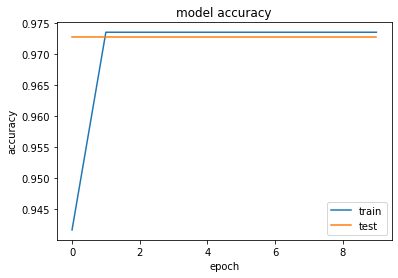

In [122]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [123]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [124]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [125]:
# check summary of the model
rnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 300)          474900    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100, 64)           23360     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 100, 11)           715       
Total params: 498,975
Trainable params: 498,975
Non-trainable params: 0
_________________________________________________________________


In [126]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
8/8 [==============================] - 2s 154ms/step - loss: 1.9568 - acc: 0.6343 - val_loss: 0.7805 - val_acc: 0.9727
Epoch 2/10
8/8 [==============================] - 1s 111ms/step - loss: 0.6028 - acc: 0.9733 - val_loss: 0.2776 - val_acc: 0.9727
Epoch 3/10
8/8 [==============================] - 1s 110ms/step - loss: 0.2475 - acc: 0.9735 - val_loss: 0.2070 - val_acc: 0.9727
Epoch 4/10
8/8 [==============================] - 1s 97ms/step - loss: 0.1958 - acc: 0.9736 - val_loss: 0.1914 - val_acc: 0.9727
Epoch 5/10
8/8 [==============================] - 1s 99ms/step - loss: 0.1819 - acc: 0.9735 - val_loss: 0.1812 - val_acc: 0.9727
Epoch 6/10
8/8 [==============================] - 1s 106ms/step - loss: 0.1708 - acc: 0.9735 - val_loss: 0.1714 - val_acc: 0.9727
Epoch 7/10
8/8 [==============================] - 1s 111ms/step - loss: 0.1609 - acc: 0.9733 - val_loss: 0.1623 - val_acc: 0.9727
Epoch 8/10
8/8 [==============================] - 1s 111ms/step - loss: 0.1481 - acc: 0.9739

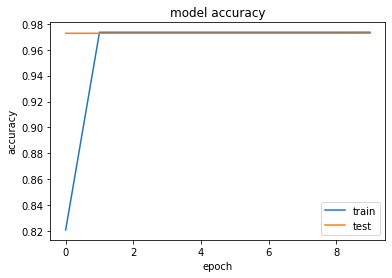

In [127]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [128]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        weights       = [embedding_weights],      # word embedding matrix
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [129]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [130]:
# check summary of the model
rnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 300)          474900    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 100, 64)           23360     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 100, 11)           715       
Total params: 498,975
Trainable params: 498,975
Non-trainable params: 0
_________________________________________________________________


In [131]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
8/8 [==============================] - 2s 142ms/step - loss: 2.0315 - acc: 0.9751 - val_loss: 1.0285 - val_acc: 0.9727
Epoch 2/10
8/8 [==============================] - 1s 113ms/step - loss: 0.8379 - acc: 0.9739 - val_loss: 0.4196 - val_acc: 0.9727
Epoch 3/10
8/8 [==============================] - 1s 113ms/step - loss: 0.3613 - acc: 0.9734 - val_loss: 0.2523 - val_acc: 0.9727
Epoch 4/10
8/8 [==============================] - 1s 111ms/step - loss: 0.2297 - acc: 0.9735 - val_loss: 0.1974 - val_acc: 0.9727
Epoch 5/10
8/8 [==============================] - 1s 99ms/step - loss: 0.1789 - acc: 0.9737 - val_loss: 0.1635 - val_acc: 0.9727
Epoch 6/10
8/8 [==============================] - 1s 97ms/step - loss: 0.1435 - acc: 0.9743 - val_loss: 0.1330 - val_acc: 0.9739
Epoch 7/10
8/8 [==============================] - 1s 109ms/step - loss: 0.1165 - acc: 0.9771 - val_loss: 0.1113 - val_acc: 0.9773
Epoch 8/10
8/8 [==============================] - 1s 106ms/step - loss: 0.0957 - acc: 0.9815

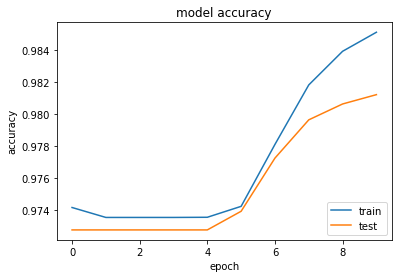

In [132]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [133]:
# create architecture

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_SIZE,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         weights       = [embedding_weights],     # word embedding matrix
                         trainable     = True                     # True - update embeddings_weight matrix
))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [134]:
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])

In [135]:
# check summary of the model
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 300)          474900    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 64)           93440     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 100, 11)           715       
Total params: 569,055
Trainable params: 569,055
Non-trainable params: 0
_________________________________________________________________


In [136]:
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
8/8 [==============================] - 5s 362ms/step - loss: 2.3204 - acc: 0.9756 - val_loss: 1.7968 - val_acc: 0.9727
Epoch 2/10
8/8 [==============================] - 2s 289ms/step - loss: 1.3212 - acc: 0.9735 - val_loss: 0.2973 - val_acc: 0.9727
Epoch 3/10
8/8 [==============================] - 2s 285ms/step - loss: 0.2682 - acc: 0.9734 - val_loss: 0.2335 - val_acc: 0.9727
Epoch 4/10
8/8 [==============================] - 2s 272ms/step - loss: 0.2250 - acc: 0.9731 - val_loss: 0.2133 - val_acc: 0.9727
Epoch 5/10
8/8 [==============================] - 2s 269ms/step - loss: 0.2011 - acc: 0.9736 - val_loss: 0.1912 - val_acc: 0.9727
Epoch 6/10
8/8 [==============================] - 2s 283ms/step - loss: 0.1802 - acc: 0.9733 - val_loss: 0.1714 - val_acc: 0.9727
Epoch 7/10
8/8 [==============================] - 2s 288ms/step - loss: 0.1595 - acc: 0.9736 - val_loss: 0.1574 - val_acc: 0.9727
Epoch 8/10
8/8 [==============================] - 2s 287ms/step - loss: 0.1461 - acc: 0.97

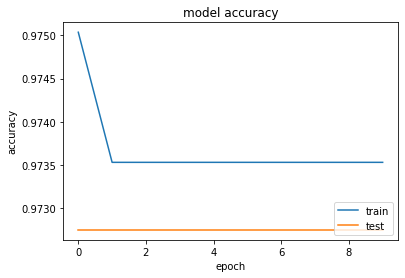

In [137]:
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [138]:
# create architecture

gru_model = Sequential()
gru_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                        output_dim    = EMBEDDING_SIZE,
                        input_length  = MAX_SEQ_LENGTH,
                        weights       = [embedding_weights],
                        trainable     = True
))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [139]:
gru_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [140]:
# check summary of model
gru_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 300)          474900    
_________________________________________________________________
gru (GRU)                    (None, 100, 64)           70272     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 100, 11)           715       
Total params: 545,887
Trainable params: 545,887
Non-trainable params: 0
_________________________________________________________________


In [141]:
gru_training = gru_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
8/8 [==============================] - 4s 288ms/step - loss: 2.3166 - acc: 0.9764 - val_loss: 1.9123 - val_acc: 0.9753
Epoch 2/10
8/8 [==============================] - 2s 242ms/step - loss: 1.6635 - acc: 0.9753 - val_loss: 0.6400 - val_acc: 0.9730
Epoch 3/10
8/8 [==============================] - 2s 252ms/step - loss: 0.4074 - acc: 0.9739 - val_loss: 0.1704 - val_acc: 0.9727
Epoch 4/10
8/8 [==============================] - 2s 251ms/step - loss: 0.1689 - acc: 0.9736 - val_loss: 0.1712 - val_acc: 0.9727
Epoch 5/10
8/8 [==============================] - 2s 250ms/step - loss: 0.1456 - acc: 0.9736 - val_loss: 0.1169 - val_acc: 0.9736
Epoch 6/10
8/8 [==============================] - 2s 250ms/step - loss: 0.0947 - acc: 0.9756 - val_loss: 0.0847 - val_acc: 0.9764
Epoch 7/10
8/8 [==============================] - 2s 233ms/step - loss: 0.0697 - acc: 0.9799 - val_loss: 0.0730 - val_acc: 0.9788
Epoch 8/10
8/8 [==============================] - 2s 245ms/step - loss: 0.0623 - acc: 0.98

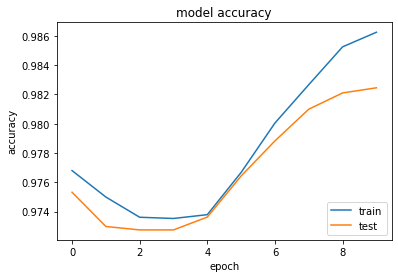

In [142]:
# visualise training history
plt.plot(gru_training.history['acc'])
plt.plot(gru_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [143]:
# create architecture

bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [144]:
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [145]:
# check summary of model
bidirect_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 300)          474900    
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          186880    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 100, 11)           1419      
Total params: 663,199
Trainable params: 663,199
Non-trainable params: 0
_________________________________________________________________


In [146]:
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
8/8 [==============================] - 9s 700ms/step - loss: 2.3037 - acc: 0.7549 - val_loss: 1.6738 - val_acc: 0.9728
Epoch 2/10
8/8 [==============================] - 5s 603ms/step - loss: 1.1472 - acc: 0.9735 - val_loss: 0.1338 - val_acc: 0.9727
Epoch 3/10
8/8 [==============================] - 5s 581ms/step - loss: 0.1287 - acc: 0.9742 - val_loss: 0.1316 - val_acc: 0.9727
Epoch 4/10
8/8 [==============================] - 5s 569ms/step - loss: 0.1236 - acc: 0.9734 - val_loss: 0.1056 - val_acc: 0.9727
Epoch 5/10
8/8 [==============================] - 5s 577ms/step - loss: 0.0938 - acc: 0.9737 - val_loss: 0.0821 - val_acc: 0.9727
Epoch 6/10
8/8 [==============================] - 4s 528ms/step - loss: 0.0741 - acc: 0.9735 - val_loss: 0.0705 - val_acc: 0.9731
Epoch 7/10
8/8 [==============================] - 5s 607ms/step - loss: 0.0649 - acc: 0.9751 - val_loss: 0.0659 - val_acc: 0.9770
Epoch 8/10
8/8 [==============================] - 5s 583ms/step - loss: 0.0613 - acc: 0.98

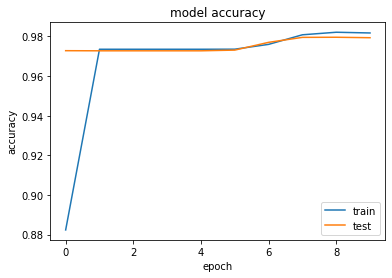

In [147]:
# visualise training history
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [148]:
loss, accuracy = rnn_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

7/7 [==============================] - 0s 8ms/step - loss: 0.0761 - acc: 0.9812
Loss: 0.07611016184091568,
Accuracy: 0.9812437891960144


In [149]:
loss, accuracy = lstm_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

7/7 [==============================] - 0s 23ms/step - loss: 0.1175 - acc: 0.9734
Loss: 0.11749482154846191,
Accuracy: 0.9733830690383911


In [150]:
loss, accuracy = gru_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

7/7 [==============================] - 0s 20ms/step - loss: 0.0582 - acc: 0.9824
Loss: 0.058219388127326965,
Accuracy: 0.9823880791664124


In [151]:
loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

7/7 [==============================] - 0s 42ms/step - loss: 0.0544 - acc: 0.9800
Loss: 0.054438453167676926,
Accuracy: 0.980049729347229
